In [1]:
pip install numpy pandas scikit-learn matplotlib seaborn xgboost lightgbm shap joblib streamlit


                                              0.0/1.5 MB ? eta -:--:--
                                              0.0/1.5 MB 640.0 kB/s eta 0:00:03
     -                                        0.0/1.5 MB 487.6 kB/s eta 0:00:03
     --                                       0.1/1.5 MB 744.7 kB/s eta 0:00:02
     ---                                      0.1/1.5 MB 726.2 kB/s eta 0:00:02
     ---                                      0.1/1.5 MB 655.8 kB/s eta 0:00:02
     ---                                      0.1/1.5 MB 655.8 kB/s eta 0:00:02
     ----                                     0.2/1.5 MB 538.9 kB/s eta 0:00:03
     ----                                     0.2/1.5 MB 538.9 kB/s eta 0:00:03
     ----                                     0.2/1.5 MB 455.1 kB/s eta 0:00:03
     ----                                     0.2/1.5 MB 455.1 kB/s eta 0:00:03
     -----                                    0.2/1.5 MB 393.0 kB/s eta 0:00:04
     ------                                   0.2

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\nazee\\anaconda3\\Lib\\site-packages\\~.mpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll'
Consider using the `--user` option or check the permissions.



In [2]:
# Heart disease prediction - end-to-end (Jupyter-friendly)
import warnings
warnings.filterwarnings("ignore")

# Standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, roc_curve, precision_recall_curve)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import joblib
import os

# Optional: SHAP for explainability
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

# 1) Load dataset

In [7]:
# Replace path if needed. There are variants; common columns: age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target
df = pd.read_csv("heart.csv")   # change path to your csv
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [8]:
display(df.tail())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


# 2) Quick EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.62376

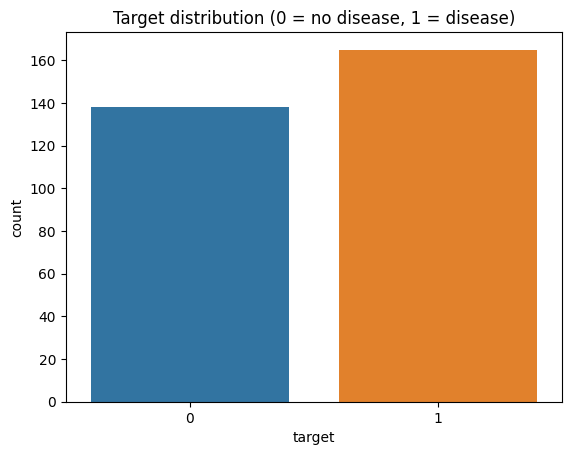

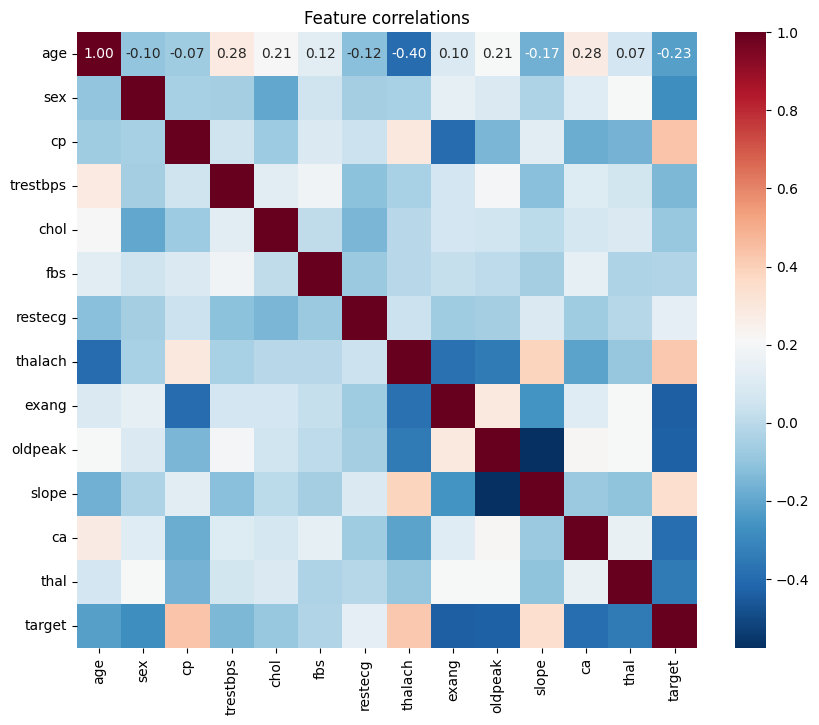

In [9]:
print(df.info())
print(df.describe())

# Check missing values
print("Missing values per column:\n", df.isna().sum())

# Target distribution
target_col = 'target'
sns.countplot(x=target_col, data=df)
plt.title("Target distribution (0 = no disease, 1 = disease)")
plt.show()

# Correlation heatmap (quick)
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="RdBu_r")
plt.title("Feature correlations")
plt.show()

# 3) Preprocessing

In [10]:
# Determine numeric vs categorical features (modify as per your dataset)
# Typical UCI heart dataset columns:
numeric_features = ['age','trestbps','chol','thalach','oldpeak']
categorical_features = ['sex','cp','fbs','restecg','exang','slope','ca','thal']  # adapt if columns differ

# If your dataset already encodes categories as numeric but are categorical, keep them in cat list.
for c in categorical_features:
    if c not in df.columns:
        categorical_features.remove(c)

X = df.drop(columns=[target_col])
y = df[target_col]

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 4) Train/test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (242, 13) (61, 13)


# 5) Define models & pipelines

In [12]:
pipelines = {}

# Logistic Regression
pipelines['logreg'] = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# Random Forest
pipelines['rf'] = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

# XGBoost
pipelines['xgb'] = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# SVM (probabilities for ROC)
pipelines['svc'] = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', SVC(probability=True, random_state=42))
])

# MLP
pipelines['mlp'] = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42))
])

# KNN
pipelines['knn'] = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

# 6) Train & cross-validate

In [13]:
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in pipelines.items():
    print("Training and CV:", name)
    # Use stratified CV ROC AUC
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    metrics = {
        'model': name,
        'cv_roc_auc_mean': np.mean(cv_scores),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    results.append(metrics)
    print(metrics)
    print(classification_report(y_test, y_pred))
    print("-"*40)

results_df = pd.DataFrame(results).sort_values(by='roc_auc', ascending=False)
display(results_df)

Training and CV: logreg
{'model': 'logreg', 'cv_roc_auc_mean': 0.8903651903651904, 'accuracy': 0.8688524590163934, 'precision': 0.8571428571428571, 'recall': 0.9090909090909091, 'f1': 0.8823529411764706, 'roc_auc': 0.9101731601731602}
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.86      0.91      0.88        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

----------------------------------------
Training and CV: rf
{'model': 'rf', 'cv_roc_auc_mean': 0.8846348096348097, 'accuracy': 0.7868852459016393, 'precision': 0.7631578947368421, 'recall': 0.8787878787878788, 'f1': 0.8169014084507042, 'roc_auc': 0.9090909090909091}
              precision    recall  f1-score   support

           0       0.83      0.68      0.75        28
           1       0.76      0.88      0.82        33

    ac

,model,cv_roc_auc_mean,accuracy,precision,recall,f1,roc_auc
0,logreg,0.890365,0.868852,0.857143,0.909091,0.882353,0.910173
3,svc,0.888617,0.836066,0.810811,0.909091,0.857143,0.910173
1,rf,0.884635,0.786885,0.763158,0.878788,0.816901,0.909091
5,knn,0.886111,0.770492,0.756757,0.848485,0.800000,0.869048
2,xgb,0.871484,0.754098,0.736842,0.848485,0.788732,0.861472
4,mlp,0.856876,0.737705,0.729730,0.818182,0.771429,0.848485


# 7) ROC Curve comparison

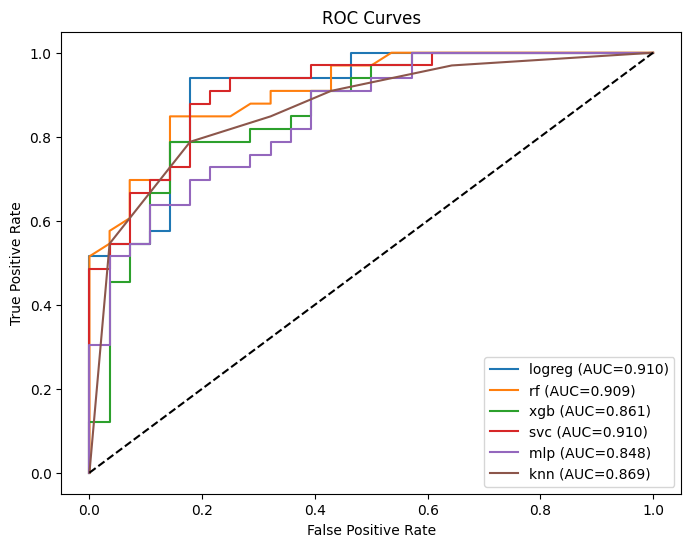

In [14]:
plt.figure(figsize=(8,6))
for name, pipe in pipelines.items():
    y_proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,y_proba):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# 8) Hyperparameter tuning example (RandomizedSearch for XGBoost)

In [15]:
param_dist_xgb = {
    'clf__n_estimators': [50,100,200,300],
    'clf__max_depth': [2,3,4,5,6],
    'clf__learning_rate': [0.01,0.05,0.1,0.2],
    'clf__subsample': [0.6,0.8,1.0],
    'clf__colsample_bytree': [0.6,0.8,1.0],
    'clf__gamma': [0,0.1,0.2]
}

rs = RandomizedSearchCV(
    pipelines['xgb'], param_distributions=param_dist_xgb,
    n_iter=30, scoring='roc_auc', n_jobs=-1, cv=skf, random_state=42, verbose=1
)
rs.fit(X_train, y_train)
print("Best XGB params:", rs.best_params_)
print("Best CV AUC:", rs.best_score_)

best_xgb = rs.best_estimator_

# Evaluate tuned XGB
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:,1]
print("Tuned XGB metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGB params: {'clf__subsample': 1.0, 'clf__n_estimators': 50, 'clf__max_depth': 6, 'clf__learning_rate': 0.05, 'clf__gamma': 0.1, 'clf__colsample_bytree': 0.6}
Best CV AUC: 0.8938746438746439
Tuned XGB metrics:
Accuracy: 0.8032786885245902
Precision: 0.7560975609756098
Recall: 0.9393939393939394
F1: 0.8378378378378378
ROC AUC: 0.8917748917748918


# 9) Feature importance (for tree models)

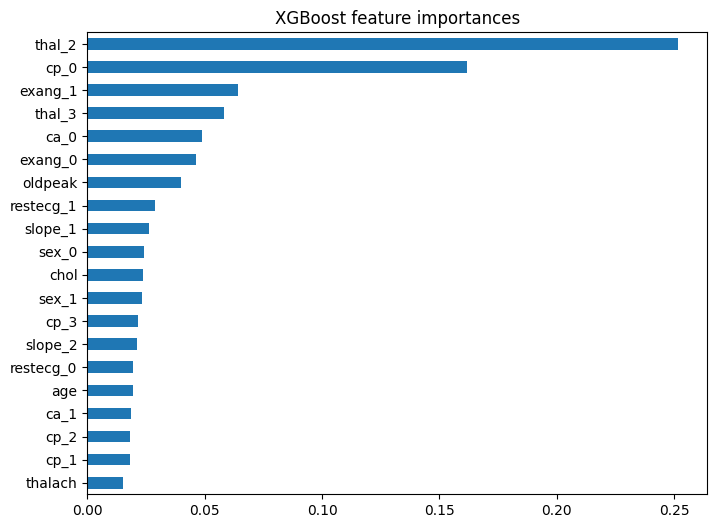

In [16]:
# To get feature names after preprocessing
pre = preprocessor.fit(X_train)  # fit to get feature names
# numeric names
num_names = numeric_features
# onehot cat names:
cat_ohe = pre.named_transformers_['cat'].named_steps['onehot']
cat_names = list(cat_ohe.get_feature_names_out(categorical_features))
feature_names = num_names + cat_names

# If best_xgb is pipeline, extract XGB feature importances
xgb_model = best_xgb.named_steps['clf']
importances = xgb_model.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(8,6))
fi.head(20).plot(kind='barh')
plt.title("XGBoost feature importances")
plt.gca().invert_yaxis()
plt.show()

# 10) SHAP (optional)

Running SHAP (this can take time)...


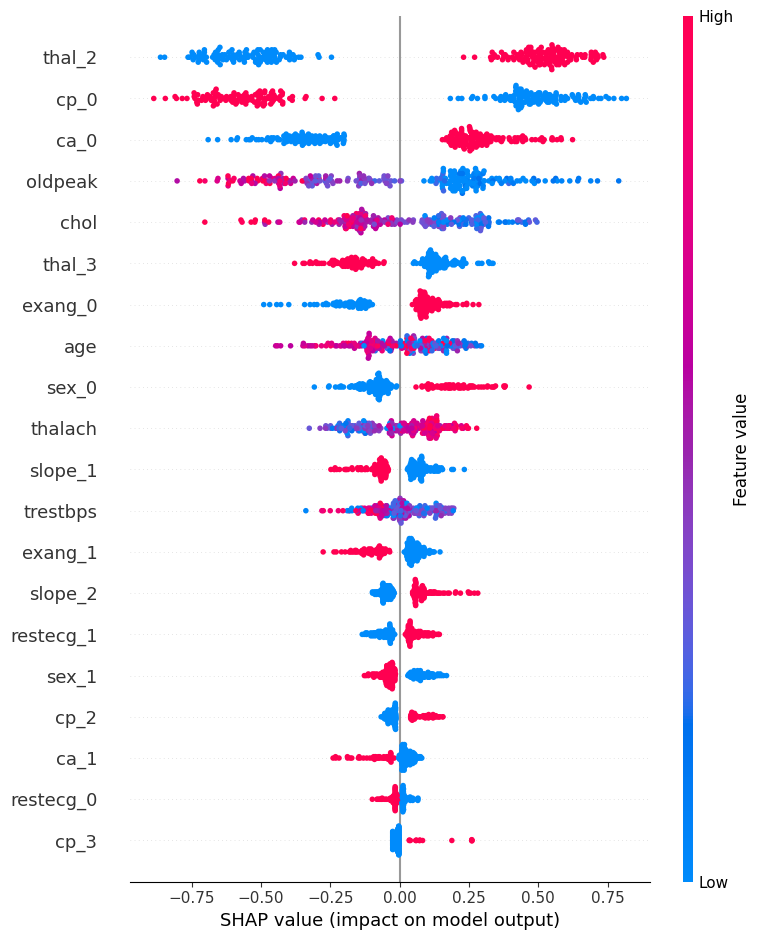

In [17]:
if SHAP_AVAILABLE:
    print("Running SHAP (this can take time)...")
    # get preprocessed data matrix for SHAP
    X_train_trans = pre.transform(X_train)
    # Use TreeExplainer for XGBoost
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_train_trans)
    # plot summary
    shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names)

In [ ]:
# 11) Save best model

In [18]:
# Choose best by roc_auc in results_df or tuned XGB
# Here we'll save tuned XGB
os.makedirs("models", exist_ok=True)
joblib.dump(best_xgb, "models/best_xgb_heart_model.joblib")
print("Saved model to models/best_xgb_heart_model.joblib")

Saved model to models/best_xgb_heart_model.joblib


# 12) Quick inference example

In [19]:
# Make one synthetic sample from X_test and predict
sample = X_test.iloc[[0]]
proba = best_xgb.predict_proba(sample)[:,1][0]
pred = best_xgb.predict(sample)[0]
print("Sample predicted proba:", proba, "pred class:", pred)

Sample predicted proba: 0.16876057 pred class: 0


In [20]:
from joblib import dump
import os

# Choose whichever model you want (here XGB, or Random Forest)
best_model = pipelines['xgb']

# create folder if not exists
os.makedirs("models", exist_ok=True)

dump(best_model, "models/best_xgb_heart_model.joblib")

print(">> Model Saved Successfully!")


>> Model Saved Successfully!
